# Vegetation detection

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS
from image_utils import get_image_data, TRAIN_TILES, TRAIN_LABEL_TILES, get_image_tile_data, compute_mean_std_on_set
from visu_utils import display_img_1b, display_labels

In [4]:
import cv2
import numpy as np
np.random.seed(2017)

### Input data

Images of shape (512, 512, 17) 

In [5]:
from unet import unet_one_test, unet_zero, unet_two, unet_one

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 4007)


Keras user configuration is setup


In [6]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [7]:
# RESIZE_TILES = False
# # tile_size = (512, 512)
# tile_size = (128, 128)
# n_channels = 17
# model = unet_zero(len(LABELS)-1, n_channels, *tile_size)

In [8]:
from glob import glob
all_train_tiles = glob(os.path.join(TRAIN_TILES, "*.tif"))
all_train_tiles = np.array([s[len(TRAIN_TILES)+1:] for s in all_train_tiles])
print "First train tile : ", all_train_tiles[0]

if False:

    from sklearn.model_selection import train_test_split 

    # TRAIN ON N TILES
    n_tiles = -1
    if n_tiles > 0:
        train_tiles, val_tiles = train_test_split(all_train_tiles[:n_tiles], test_size=0.3)
    else:
        train_tiles, val_tiles = train_test_split(all_train_tiles, test_size=0.3)

    print "Train/Test : ", len(train_tiles), len(val_tiles)
    
    logging.getLogger().setLevel(logging.INFO)
    mean_tile_image, std_tile_image = compute_mean_std_on_set(train_tiles)
    logging.getLogger().setLevel(logging.WARN)
    
else:
    ll = int(len(all_train_tiles)*0.7)
    train_tiles = all_train_tiles[:ll]
    val_tiles = all_train_tiles[ll:]
    
    mean_tile_fname = os.path.join(TRAIN_TILES, 'mean_tile_image.npz')
    std_tile_fname = os.path.join(TRAIN_TILES, 'std_tile_image.npz')
    if not os.path.exists(mean_tile_fname) or not os.path.exists(std_tile_fname):
        logging.getLogger().setLevel(logging.INFO)
        mean_tile_image, std_tile_image = compute_mean_std_on_set(train_tiles)
        logging.getLogger().setLevel(logging.WARN)
        np.savez(mean_tile_fname, mean_tile_image)
        np.savez(std_tile_fname, std_tile_image)
    else:
        mean_tile_image = np.load(mean_tile_fname)['arr_0']
        std_tile_image = np.load(std_tile_fname)['arr_0']
        
    print mean_tile_image.shape, std_tile_image.shape

First train tile :  6010_1_2_0_0.tif
(256L, 256L, 17L) (256L, 256L, 17L)


In [9]:
def normalize_image(img_data, mean_image=None, std_image=None):
    out = img_data.astype(np.float32)    
    if mean_image is not None or std_image is not None:
        out -= mean_image 
        out /= std_image
    out = out.transpose([2,0,1])
    return out


def generate_images(train_tiles, batch_size, print_tile_id=False):
    while True:
        n = len(train_tiles)
        n_batches = n // batch_size
        random_indices = np.arange(n)
        np.random.shuffle(random_indices)
        for i in range(n_batches):
            end = min((i+1)*batch_size, n) 
            batch_indices = random_indices[batch_size*i:end]
            X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
            Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
            for j, tile_id in enumerate(train_tiles[batch_indices]):
                if print_tile_id:
                    print("Tile id: %s" % tile_id)
                x = get_image_tile_data(os.path.join(TRAIN_TILES,tile_id))
                y = get_image_tile_data(os.path.join(TRAIN_LABEL_TILES,tile_id))
                
                if n_labels < len(LABELS) - 1:
                    y = y[:,:,labels]
                if n_channels < 17:
                    x = x[:,:,channels]

                x = normalize_image(x, mean_tile_image[:,:,channels], std_tile_image[:,:,channels])
                y = normalize_image(y)     
                
                X[j,:,:,:] = x
                Y[j,:,:,:] = y 
                
            yield (X, Y)

In [10]:
tile_size = (256, 256)
# channels = np.array(range(17))
channels = np.array([0, 1, 2, 3, 4])
n_channels = len(channels)

# labels = np.array(range(len(LABELS)))
labels = np.array([0, 5, 6, 2])
n_labels = len(labels)

Tile id: 6040_2_2_384_0.tif
Tile id: 6100_2_3_3072_2176.tif
Tile id: 6040_1_0_2176_2176.tif
Tile id: 6110_4_0_2624_1728.tif
Tile id: 6070_2_3_1728_0.tif
(5L, 5L, 256L, 256L) (5L, 4L, 256L, 256L)
-0.0624735 0.181634 0.0 1.0


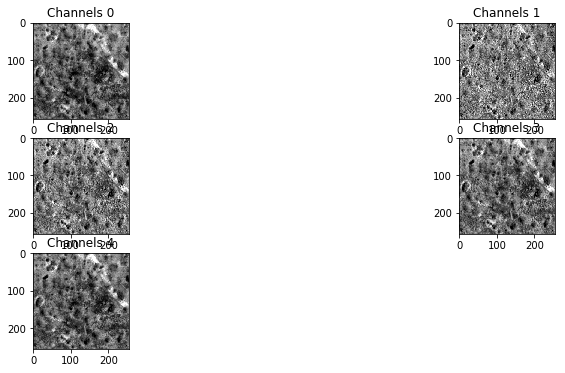

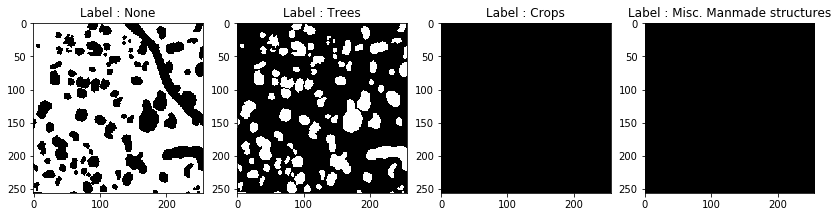

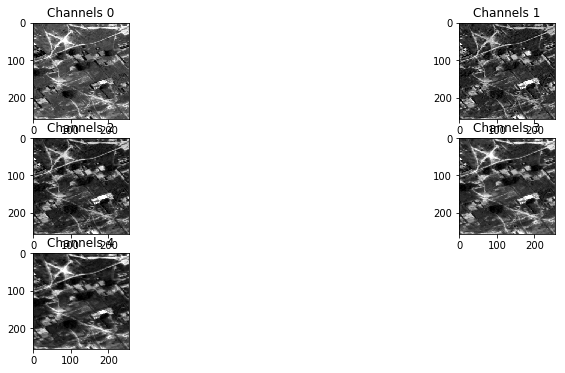

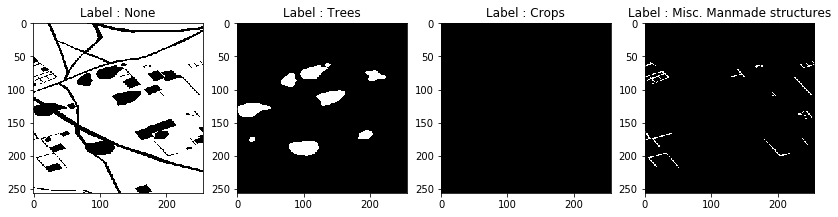

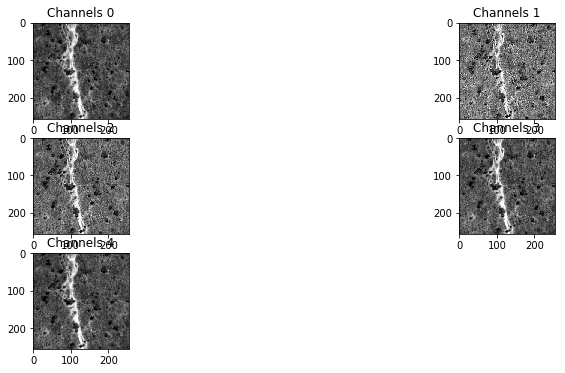

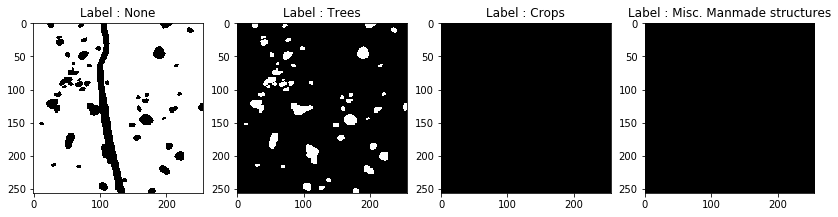

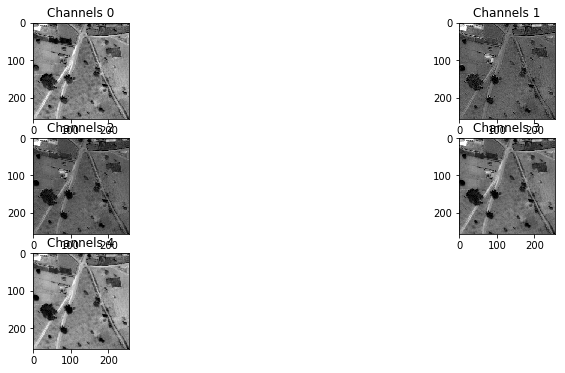

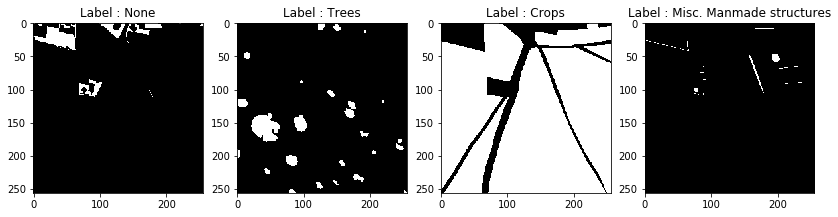

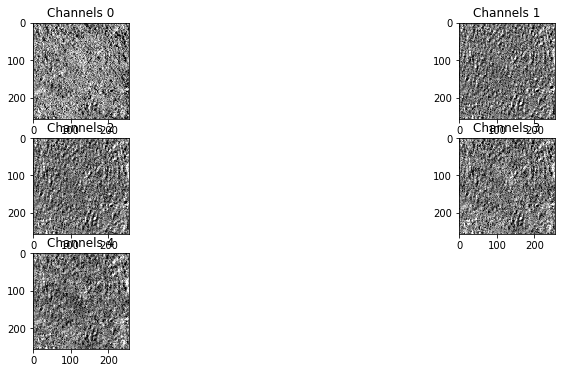

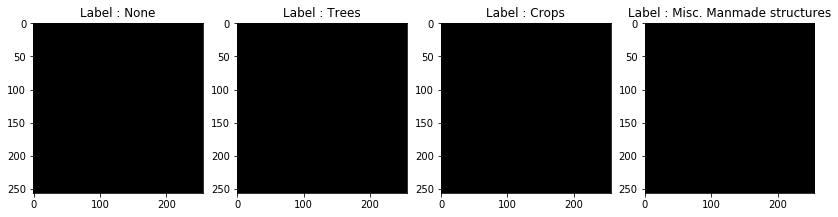

In [11]:
batch_size = 5
for X, Y in generate_images(train_tiles, batch_size, print_tile_id=True):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        plt.figure(figsize=(14, 6))
        n, m = 3, int(n_channels * 1.0 / 3.0 + 0.5), 
        for j in range(n_channels):
            plt.subplot(n,m,j+1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 0.5), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [17]:
import os
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

In [18]:
deep=False 
n_filters_0=16

model = unet_two(n_labels, n_channels, *tile_size, deep=deep, n_filters_0=n_filters_0)

weights_filename = os.path.join("weights", "unet_two_%i_%i_%s_%i.h5.store" % (n_channels, n_labels, str(deep), n_filters_0))
# if os.path.exists(weights_filename):
#     print "Found weights file %s" % weights_filename
#     model.load_weights(weights_filename)

In [19]:
channels, labels, np.array(LABELS)[labels]

(array([0, 1, 2, 3, 4]),
 array([0, 5, 6, 2]),
 array(['None', 'Trees', 'Crops', 'Misc. Manmade structures'], 
       dtype='|S24'))

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 5, 256, 256)   0                                            
____________________________________________________________________________________________________
convolution2d_28 (Convolution2D) (None, 16, 256, 256)  736         input_2[0][0]                    
____________________________________________________________________________________________________
inverse_3 (Inverse)              (None, 16, 256, 256)  0           convolution2d_28[0][0]           
____________________________________________________________________________________________________
inverse_4 (Inverse)              (None, 16, 256, 256)  0           convolution2d_28[0][0]           
___________________________________________________________________________________________

In [21]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
# earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)
# LearningRateScheduler

In [22]:
# model.compile(optimizer=Nadam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

model.compile(optimizer=Adadelta(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

We have 25 images splitted into 64 tiles. It gives 1600 tiles to train on.
Train/test split with test size 0.3 gives: 1120 and 480 number of tiles.
Assembling 32 tiles in a batch, we obtain 35 batches for training tiles and 15 batches for validation.

In [23]:
# from keras.callbacks import RemoteMonitor
# rmon = RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers={'Content-Type': 'application/json', 'Accept': 'application/json'})

In [ ]:
foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = foo(len(train_tiles))
nb_val_samples = foo(len(val_tiles))


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_tiles, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=20,
    validation_data=generate_images(val_tiles, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

4 112 48
Epoch 1/20
23s - loss: 346.3310 - jaccard_coef: 1.2790e-05 - jaccard_coef_int: 2.0600e-14 - acc: 0.0983 - val_loss: 344.5752 - val_jaccard_coef: 1.3626e-05 - val_jaccard_coef_int: 1.5961e-14 - val_acc: 0.1812
Epoch 2/20
23s - loss: 349.5196 - jaccard_coef: 1.2856e-05 - jaccard_coef_int: 1.3975e-14 - acc: 0.0829 - val_loss: 356.8336 - val_jaccard_coef: 1.3409e-05 - val_jaccard_coef_int: 2.1259e-14 - val_acc: 0.2006
Epoch 3/20
23s - loss: 341.7183 - jaccard_coef: 1.2261e-05 - jaccard_coef_int: 2.2496e-14 - acc: 0.1047 - val_loss: 352.8214 - val_jaccard_coef: 1.2709e-05 - val_jaccard_coef_int: 3.1386e-14 - val_acc: 0.1755
Epoch 4/20
23s - loss: 348.2526 - jaccard_coef: 1.2663e-05 - jaccard_coef_int: 5.3691e-08 - acc: 0.0992 - val_loss: 343.3307 - val_jaccard_coef: 1.3684e-05 - val_jaccard_coef_int: 1.0561e-14 - val_acc: 0.1831
Epoch 5/20
23s - loss: 345.5303 - jaccard_coef: 1.2826e-05 - jaccard_coef_int: 1.4321e-14 - acc: 0.0970 - val_loss: 350.7426 - val_jaccard_coef: 1.4220e-05

In [107]:
# model.save_weights(weights_filename)

If `nan` appears, analyse a step by step

In [21]:
batch_size = 10
for X, Y in generate_images(train_tiles, batch_size, print_tile_id=True):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()

    hist = model.fit(X, Y, batch_size=batch_size//2, nb_epoch=5, verbose=2)
    Y_pred = model.predict(X, batch_size=batch_size//2)
    print Y_pred.min(), Y_pred.max()
    break

Tile id: 6110_3_1_0_384.tif
Tile id: 6100_2_2_1728_384.tif
Tile id: 6100_2_2_832_1728.tif
Tile id: 6110_1_2_3072_1728.tif
Tile id: 6010_4_4_384_3072.tif
Tile id: 6040_1_0_384_1280.tif
Tile id: 6040_2_2_2624_1728.tif
Tile id: 6040_2_2_384_384.tif
Tile id: 6040_2_2_832_0.tif
Tile id: 6100_2_2_2176_2624.tif
(10L, 5L, 256L, 256L) (10L, 4L, 256L, 256L)
-0.0502791 0.190906 0.0 1.0
Epoch 1/5


MemoryError: Error allocating 20971520 bytes of device memory (CNMEM_STATUS_OUT_OF_MEMORY).
Apply node that caused the error: GpuAllocEmpty(Assert{msg='The convolution would produce an invalid shape (dim[0] < 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[1] < 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[2] <= 0).'}.0, Assert{msg='The convolution would produce an invalid shape (dim[3] <= 0).'}.0)
Toposort index: 1252
Inputs types: [TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(), (), (), ()]
Inputs strides: [(), (), (), ()]
Inputs values: [array(5L, dtype=int64), array(16L, dtype=int64), array(256L, dtype=int64), array(256L, dtype=int64)]
Outputs clients: [[GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [23]:
layer = model.get_layer(index=2)
print layer.weights
print layer.W.eval()[0,0,:,:]

layer = model.get_layer(index=1)
print layer.weights
print layer.W.eval()[0,0,:,:]
layer = model.get_layer(index=5)
print layer.weights
print layer.W.eval()[0,0,:,:]

[convolution2d_4_W, convolution2d_4_b]
[[ 0.20707504  0.11569368 -0.26223308]
 [-0.037168    0.14761208  0.18767962]
 [-0.03102852 -0.20170985 -0.04872162]]
[convolution2d_3_W, convolution2d_3_b]
[[ 0.22671278  0.2578637   0.17819569]
 [-0.00840357  0.07493455 -0.24825001]
 [ 0.14824052  0.03659624 -0.11134839]]
[convolution2d_5_W, convolution2d_5_b]
[[ 0.46003461]]


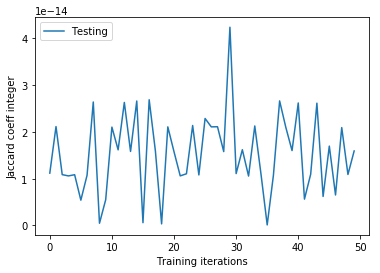

In [21]:
plt.plot(history.history['val_jaccard_coef_int'])
plt.ylabel('Jaccard coeff integer')
# plt.plot(history.history['val_jaccard_coef'])
# plt.ylabel('Jaccard coeff')
# plt.plot(history.history['loss'])
# plt.ylabel('loss')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [27]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5L, 4L, 256L, 256L) 1.38915e-05 1.55844e-05


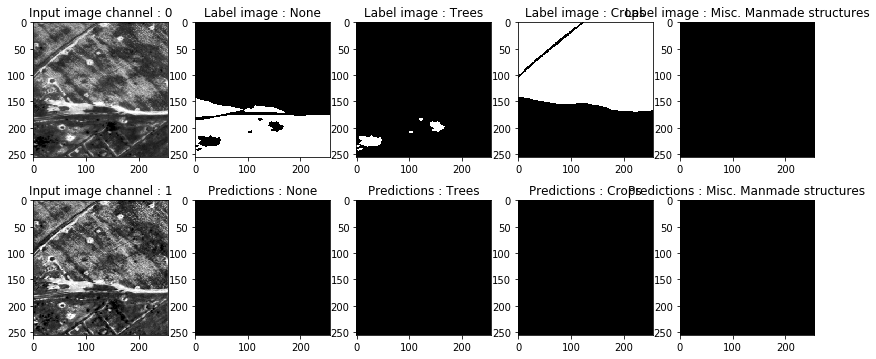

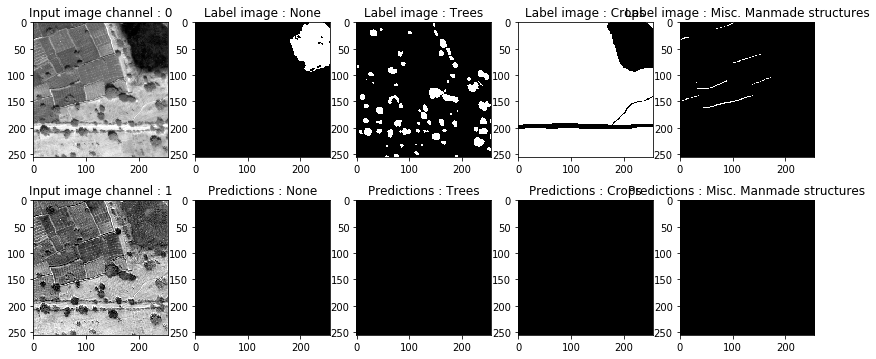

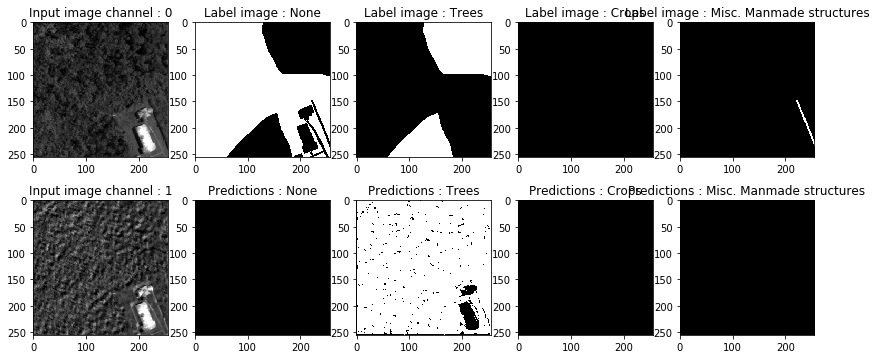

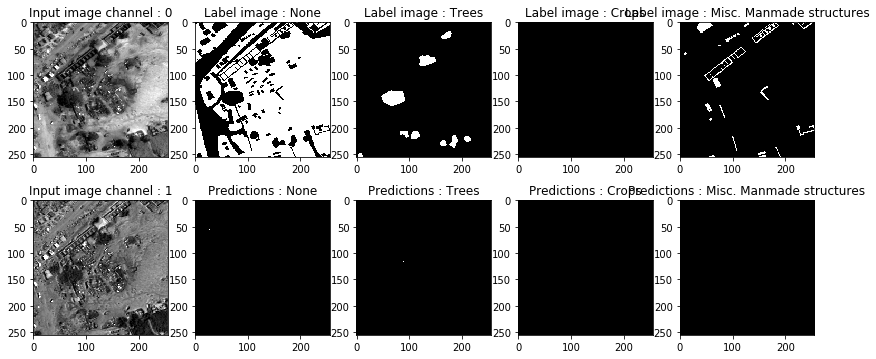

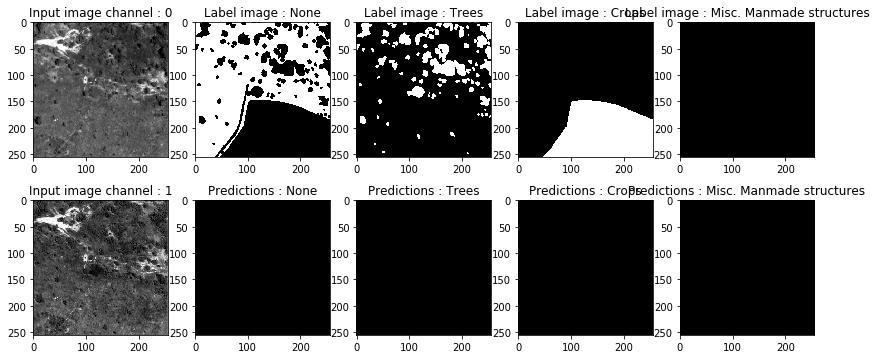

In [22]:
batch_size = 5

for X, Y in generate_images(train_tiles, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


In [ ]:
_plot(X, Y, Y_pred, 0, 0)

In [ ]:
y = Y_pred[0,2,:,:]
print y.min(), y.max()